# Loan Default Prediction
## Team Members:
yuanhao jiang

zixiong du

jiahui zhang

xinxin zhang

In [2]:
import warnings
warnings.simplefilter('ignore')

import os
import re
import gc

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)

from tqdm.notebook import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import lightgbm as lgb

# Load_data

In [33]:
train_data = pd.read_csv('train_public.csv')
print(train_data.shape)
train_data.head()
data = pd.read_csv('data.csv')

(10000, 39)


In [34]:
train_internet = pd.read_csv('train_internet.csv')
print(train_internet.shape)
train_internet.head()
test_data = pd.read_csv('test_public.csv')
print(test_data.shape)
test_data.head()

(750000, 42)
(5000, 38)


,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon
0,1000575,200575,2890.909,3,10.791,88.010,B,幼教与中小学校,住宿和餐饮业,5 years,0,1,2017/12/1,0,314,0,23.040,0,745.000,869.167,7,0,0.000,8647.692,31.846,1,0,3-Mar,0,1,2.000,0.000,15.000,5.000,4.000,3,773,89.192
1,1028125,228125,7272.727,3,9.990,258.100,B,普通企业,批发和零售业,10+ years,1,1,2015/7/1,5,29,19,27.755,0,681.818,738.636,24,0,0.000,9406.154,18.277,0,0,Dec-99,6,1,8.000,0.000,8.000,29.000,14.000,1,1894,218.538
2,1010694,210694,26295.455,3,15.763,764.030,C,普通企业,住宿和餐饮业,10+ years,0,2,2013/4/1,0,488,24,25.495,1,758.182,947.727,11,0,0.000,26414.769,62.300,1,0,Apr-99,268,1,6.000,0.000,4.000,10.000,6.000,1,5670,1221.231
3,1026712,226712,22690.909,5,19.305,524.300,D,普通企业,采矿业,10+ years,0,2,2017/12/1,0,489,30,10.620,0,572.727,620.455,8,0,0.000,1198.000,7.700,0,0,Jul-00,0,1,4.000,0.000,12.000,10.000,8.000,2,4800,443.077
4,1002895,202895,14545.455,3,7.139,490.320,A,世界五百强,金融业,1 year,0,0,2016/6/1,2,418,45,6.611,0,638.182,691.364,15,0,0.000,3920.000,8.831,1,0,7-May,5,1,4.000,0.000,7.000,14.000,9.000,0,3516,649.108


In [35]:
train_data['isDefault'].value_counts(dropna=True)

0    8317
1    1683
Name: isDefault, dtype: int64

In [36]:
train_internet = train_internet.rename(columns={'is_default': 'isDefault'})
train_internet['isDefault'].value_counts(dropna=True)

0    600327
1    149673
Name: isDefault, dtype: int64

# Data cleaning

In [37]:
drop1 = ['sub_class', 'work_type', 'house_loan_status', 'marriage', 'offsprings', 'f5']
drop2 = ['known_outstanding_loan', 'known_dero', 'app_type']

train_internet.drop(drop1 + ['user_id'], axis=1, inplace=True)
train_data.drop(drop2 + ['user_id'], axis=1, inplace=True)

train_data = pd.concat([train_data, train_internet]).reset_index(drop=True)
print(train_data.shape)
train_data.head()

(760000, 35)


,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
0,1040418,31818.182,3,11.466,1174.910,C,政府机构,金融业,3 years,0,1,2016/10/1,2,193.000,13,2.430,0.000,556.364,649.091,0.000,7734.231,91.800,0,1-Dec,5.000,1.000,1.000,0.000,4.000,5.000,4.000,3,9927,0.000,0
1,1025197,28000.000,5,16.841,670.690,C,政府机构,金融业,10+ years,0,2,2013/6/1,0,491.000,30,11.005,1.000,715.000,893.750,0.000,31329.000,54.800,1,Apr-90,40642.000,1.000,7.000,0.000,4.000,45.000,22.000,0,0,0.000,0
2,1009360,17272.727,3,8.900,603.320,A,政府机构,公共服务、社会组织,10+ years,1,0,2014/1/1,4,459.000,8,6.409,0.000,774.545,903.636,0.000,18514.000,57.692,1,Oct-91,154.000,1.000,6.000,0.000,6.000,28.000,19.000,0,0,0.000,0
3,1039708,20000.000,3,4.788,602.300,A,世界五百强,文化和体育业,6 years,0,1,2015/7/1,0,157.000,8,9.205,0.000,750.000,875.000,0.000,20707.000,42.600,0,1-Jun,0.000,1.000,5.000,0.000,10.000,15.000,9.000,0,0,0.000,0
4,1027483,15272.727,3,12.790,470.310,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,2016/7/1,0,38.000,21,15.578,0.000,609.091,710.606,0.000,14016.154,30.462,0,2-May,0.000,1.000,10.000,0.000,6.000,15.000,4.000,0,0,0.000,0


In [38]:
test_data.drop(drop2 + ['user_id'], axis=1, inplace=True)

print(test_data.shape)
test_data.head()

(5000, 34)


,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon
0,1000575,2890.909,3,10.791,88.010,B,幼教与中小学校,住宿和餐饮业,5 years,0,1,2017/12/1,0,314,0,23.040,0,745.000,869.167,0.000,8647.692,31.846,1,3-Mar,0,1,2.000,0.000,15.000,5.000,4.000,3,773,89.192
1,1028125,7272.727,3,9.990,258.100,B,普通企业,批发和零售业,10+ years,1,1,2015/7/1,5,29,19,27.755,0,681.818,738.636,0.000,9406.154,18.277,0,Dec-99,6,1,8.000,0.000,8.000,29.000,14.000,1,1894,218.538
2,1010694,26295.455,3,15.763,764.030,C,普通企业,住宿和餐饮业,10+ years,0,2,2013/4/1,0,488,24,25.495,1,758.182,947.727,0.000,26414.769,62.300,1,Apr-99,268,1,6.000,0.000,4.000,10.000,6.000,1,5670,1221.231
3,1026712,22690.909,5,19.305,524.300,D,普通企业,采矿业,10+ years,0,2,2017/12/1,0,489,30,10.620,0,572.727,620.455,0.000,1198.000,7.700,0,Jul-00,0,1,4.000,0.000,12.000,10.000,8.000,2,4800,443.077
4,1002895,14545.455,3,7.139,490.320,A,世界五百强,金融业,1 year,0,0,2016/6/1,2,418,45,6.611,0,638.182,691.364,0.000,3920.000,8.831,1,7-May,5,1,4.000,0.000,7.000,14.000,9.000,0,3516,649.108


# Merged datasets of test and train

In [39]:
# data = pd.concat([train_data, test_data])
# print(data.shape)
# data.head()
train_data

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
0,1040418,31818.182,3,11.466,1174.910,C,政府机构,金融业,3 years,0,1,2016/10/1,2,193.000,13,2.430,0.000,556.364,649.091,0.000,7734.231,91.800,0,1-Dec,5.000,1.000,1.000,0.000,4.000,5.000,4.000,3,9927,0.000,0
1,1025197,28000.000,5,16.841,670.690,C,政府机构,金融业,10+ years,0,2,2013/6/1,0,491.000,30,11.005,1.000,715.000,893.750,0.000,31329.000,54.800,1,Apr-90,40642.000,1.000,7.000,0.000,4.000,45.000,22.000,0,0,0.000,0
2,1009360,17272.727,3,8.900,603.320,A,政府机构,公共服务、社会组织,10+ years,1,0,2014/1/1,4,459.000,8,6.409,0.000,774.545,903.636,0.000,18514.000,57.692,1,Oct-91,154.000,1.000,6.000,0.000,6.000,28.000,19.000,0,0,0.000,0
3,1039708,20000.000,3,4.788,602.300,A,世界五百强,文化和体育业,6 years,0,1,2015/7/1,0,157.000,8,9.205,0.000,750.000,875.000,0.000,20707.000,42.600,0,1-Jun,0.000,1.000,5.000,0.000,10.000,15.000,9.000,0,0,0.000,0
4,1027483,15272.727,3,12.790,470.310,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,2016/7/1,0,38.000,21,15.578,0.000,609.091,710.606,0.000,14016.154,30.462,0,2-May,0.000,1.000,10.000,0.000,6.000,15.000,4.000,0,0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759995,624287,12000.000,3,11.470,395.550,B,上市企业,文化和体育业,4 years,0,1,2016-02-01,0,95.000,13,21.550,0.000,665.000,669.000,0.000,9572.000,62.200,0,Jun-1995,0.000,1.000,6.000,0.000,8.000,22.000,12.000,0,0,0.000,0
759996,427602,12000.000,3,6.030,365.230,A,政府机构,住宿和餐饮业,8 years,1,2,2014-03-01,4,74.000,30,4.520,0.000,770.000,774.000,0.000,14183.000,30.500,1,Sep-2001,4.000,1.000,2.000,0.000,7.000,4.000,4.000,6,810,352.902,0
759997,206828,10000.000,3,15.410,348.670,D,政府机构,住宿和餐饮业,8 years,1,2,2015-12-01,7,74.000,30,17.250,0.000,665.000,669.000,0.000,9259.000,72.900,0,Oct-2008,8.000,1.000,6.000,0.000,10.000,11.000,3.000,0,0,0.000,0
759998,293912,7200.000,3,9.440,230.440,B,政府机构,信息传输、软件和信息技术服务业,10+ years,2,2,2017-12-01,0,134.000,8,24.850,0.000,675.000,679.000,1.000,9825.000,71.200,0,Apr-2006,0.000,1.000,7.000,0.000,9.000,11.000,6.000,0,0,0.000,0


# Data Transformation

<p>
<span style="color:blue">
    Data Encoding<br>
> issue_date -this feature was not formatted properly - encoded to numerical values. <br>
> class - this is feature in the dataset which had to be labled. <br>
> employer_type - this is feature in the dataset which had to be labled. <br>
> industry - this is feature in the dataset which had to be labled. <br>
> work_year - this feature was not formatted properly. It has some values which was in the format like "10+ years"...etc. we changed them to numerical values in the below cell.
> earlies_credit_mon - this feature was not formatted properly. It has some values which was in the format like "Apr-90"...etc. we changed them to numerical values in the below cell.
    
</span>
</p>

In [40]:
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
train_data['issue_mon'] = train_data['issue_date'].dt.year * 100 + train_data['issue_date'].dt.month
train_data.drop(['issue_date'], axis=1, inplace=True)
train_data.head()

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_mon
0,1040418,31818.182,3,11.466,1174.910,C,政府机构,金融业,3 years,0,1,2,193.000,13,2.430,0.000,556.364,649.091,0.000,7734.231,91.800,0,1-Dec,5.000,1.000,1.000,0.000,4.000,5.000,4.000,3,9927,0.000,0,201610
1,1025197,28000.000,5,16.841,670.690,C,政府机构,金融业,10+ years,0,2,0,491.000,30,11.005,1.000,715.000,893.750,0.000,31329.000,54.800,1,Apr-90,40642.000,1.000,7.000,0.000,4.000,45.000,22.000,0,0,0.000,0,201306
2,1009360,17272.727,3,8.900,603.320,A,政府机构,公共服务、社会组织,10+ years,1,0,4,459.000,8,6.409,0.000,774.545,903.636,0.000,18514.000,57.692,1,Oct-91,154.000,1.000,6.000,0.000,6.000,28.000,19.000,0,0,0.000,0,201401
3,1039708,20000.000,3,4.788,602.300,A,世界五百强,文化和体育业,6 years,0,1,0,157.000,8,9.205,0.000,750.000,875.000,0.000,20707.000,42.600,0,1-Jun,0.000,1.000,5.000,0.000,10.000,15.000,9.000,0,0,0.000,0,201507
4,1027483,15272.727,3,12.790,470.310,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,0,38.000,21,15.578,0.000,609.091,710.606,0.000,14016.154,30.462,0,2-May,0.000,1.000,10.000,0.000,6.000,15.000,4.000,0,0,0.000,0,201607


In [41]:
test_data['issue_date'] = pd.to_datetime(test_data['issue_date'])
test_data['issue_mon'] = test_data['issue_date'].dt.year * 100 + test_data['issue_date'].dt.month
test_data.drop(['issue_date'], axis=1, inplace=True)
test_data.head()

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,issue_mon
0,1000575,2890.909,3,10.791,88.010,B,幼教与中小学校,住宿和餐饮业,5 years,0,1,0,314,0,23.040,0,745.000,869.167,0.000,8647.692,31.846,1,3-Mar,0,1,2.000,0.000,15.000,5.000,4.000,3,773,89.192,201712
1,1028125,7272.727,3,9.990,258.100,B,普通企业,批发和零售业,10+ years,1,1,5,29,19,27.755,0,681.818,738.636,0.000,9406.154,18.277,0,Dec-99,6,1,8.000,0.000,8.000,29.000,14.000,1,1894,218.538,201507
2,1010694,26295.455,3,15.763,764.030,C,普通企业,住宿和餐饮业,10+ years,0,2,0,488,24,25.495,1,758.182,947.727,0.000,26414.769,62.300,1,Apr-99,268,1,6.000,0.000,4.000,10.000,6.000,1,5670,1221.231,201304
3,1026712,22690.909,5,19.305,524.300,D,普通企业,采矿业,10+ years,0,2,0,489,30,10.620,0,572.727,620.455,0.000,1198.000,7.700,0,Jul-00,0,1,4.000,0.000,12.000,10.000,8.000,2,4800,443.077,201712
4,1002895,14545.455,3,7.139,490.320,A,世界五百强,金融业,1 year,0,0,2,418,45,6.611,0,638.182,691.364,0.000,3920.000,8.831,1,7-May,5,1,4.000,0.000,7.000,14.000,9.000,0,3516,649.108,201606


In [42]:
train_data['class'] = train_data['class'].map({
    'A': 0, 'B': 1, 'C': 2, 'D': 3,
    'E': 4, 'F': 5, 'G': 6
})

In [43]:
test_data['class'] = test_data['class'].map({
    'A': 0, 'B': 1, 'C': 2, 'D': 3,
    'E': 4, 'F': 5, 'G': 6
})

In [44]:
lbe = LabelEncoder()
train_data['employer_type'] = lbe.fit_transform(train_data['employer_type'])
train_data.head()
test_data['employer_type'] = lbe.fit_transform(test_data['employer_type'])
test_data.head()

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,issue_mon
0,1000575,2890.909,3,10.791,88.010,1,2,住宿和餐饮业,5 years,0,1,0,314,0,23.040,0,745.000,869.167,0.000,8647.692,31.846,1,3-Mar,0,1,2.000,0.000,15.000,5.000,4.000,3,773,89.192,201712
1,1028125,7272.727,3,9.990,258.100,1,4,批发和零售业,10+ years,1,1,5,29,19,27.755,0,681.818,738.636,0.000,9406.154,18.277,0,Dec-99,6,1,8.000,0.000,8.000,29.000,14.000,1,1894,218.538,201507
2,1010694,26295.455,3,15.763,764.030,2,4,住宿和餐饮业,10+ years,0,2,0,488,24,25.495,1,758.182,947.727,0.000,26414.769,62.300,1,Apr-99,268,1,6.000,0.000,4.000,10.000,6.000,1,5670,1221.231,201304
3,1026712,22690.909,5,19.305,524.300,3,4,采矿业,10+ years,0,2,0,489,30,10.620,0,572.727,620.455,0.000,1198.000,7.700,0,Jul-00,0,1,4.000,0.000,12.000,10.000,8.000,2,4800,443.077,201712
4,1002895,14545.455,3,7.139,490.320,0,1,金融业,1 year,0,0,2,418,45,6.611,0,638.182,691.364,0.000,3920.000,8.831,1,7-May,5,1,4.000,0.000,7.000,14.000,9.000,0,3516,649.108,201606


In [45]:
lbe = LabelEncoder()
train_data['industry'] = lbe.fit_transform(train_data['industry'])
test_data['industry'] = lbe.fit_transform(test_data['industry'])

In [46]:
train_data['work_year'] = train_data['work_year'].map({
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
    '10+ years': 10
})

train_data['work_year'].fillna(-1, inplace=True)

In [47]:
test_data['work_year'] = test_data['work_year'].map({
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
    '10+ years': 10
})

test_data['work_year'].fillna(-1, inplace=True)

In [48]:
def clean_mon(x):
    mons = {'jan':1, 'feb':2, 'mar':3, 'apr':4,  'may':5,  'jun':6,
            'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
    year_group = re.search('(\d+)', x)
    if year_group:
        year = int(year_group.group(1))
        if year < 22:
            year += 2000
        elif 100 > year > 22:
            year += 1900
        else:
            year = 2022
    else:
        year = 2022
        
    month_group = re.search('([a-zA-Z]+)', x)
    if month_group:
        mon = month_group.group(1).lower()
        month = mons[mon]
    else:
        month = 0
        
    return year*100 + month

train_data['earlies_credit_mon'] = train_data['earlies_credit_mon'].apply(lambda x: clean_mon(x))
test_data['earlies_credit_mon'] = test_data['earlies_credit_mon'].apply(lambda x: clean_mon(x))

In [49]:
train_data.head()

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_mon
0,1040418,31818.182,3,11.466,1174.910,2,3,13,3.000,0,1,2,193.000,13,2.430,0.000,556.364,649.091,0.000,7734.231,91.800,0,200112,5.000,1.000,1.000,0.000,4.000,5.000,4.000,3,9927,0.000,0,201610
1,1025197,28000.000,5,16.841,670.690,2,3,13,10.000,0,2,0,491.000,30,11.005,1.000,715.000,893.750,0.000,31329.000,54.800,1,199004,40642.000,1.000,7.000,0.000,4.000,45.000,22.000,0,0,0.000,0,201306
2,1009360,17272.727,3,8.900,603.320,0,3,3,10.000,1,0,4,459.000,8,6.409,0.000,774.545,903.636,0.000,18514.000,57.692,1,199110,154.000,1.000,6.000,0.000,6.000,28.000,19.000,0,0,0.000,0,201401
3,1039708,20000.000,3,4.788,602.300,0,1,10,6.000,0,1,0,157.000,8,9.205,0.000,750.000,875.000,0.000,20707.000,42.600,0,200106,0.000,1.000,5.000,0.000,10.000,15.000,9.000,0,0,0.000,0,201507
4,1027483,15272.727,3,12.790,470.310,2,3,2,0.000,2,1,0,38.000,21,15.578,0.000,609.091,710.606,0.000,14016.154,30.462,0,200205,0.000,1.000,10.000,0.000,6.000,15.000,4.000,0,0,0.000,0,201607


In [50]:
train_data.shape

(760000, 35)

In [51]:
train_data.info

<bound method DataFrame.info of         loan_id  total_loan  year_of_loan  interest  monthly_payment  class  \
0       1040418   31818.182             3    11.466         1174.910      2   
1       1025197   28000.000             5    16.841          670.690      2   
2       1009360   17272.727             3     8.900          603.320      0   
3       1039708   20000.000             3     4.788          602.300      0   
4       1027483   15272.727             3    12.790          470.310      2   
...         ...         ...           ...       ...              ...    ...   
759995   624287   12000.000             3    11.470          395.550      1   
759996   427602   12000.000             3     6.030          365.230      0   
759997   206828   10000.000             3    15.410          348.670      3   
759998   293912    7200.000             3     9.440          230.440      1   
759999   381388   16000.000             5    19.220          416.990      3   

        employer_ty

# Missing value

## Function to calculate missing values by column

In [52]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [53]:
missing_values_table(data)

Your selected dataframe has 26 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
isDefault,4996,0.700


In [54]:
data

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,post_code,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,policy_code,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_mon
0,1040418,31818.182,3,11.466,1174.910,2,3,13,3.000,0,193.000,2.430,0.000,556.364,649.091,0.000,7734.231,91.800,0,200112,1.000,3,9927,0.000,0.000,201610
1,1025197,28000.000,5,16.841,670.690,2,3,13,10.000,0,491.000,11.005,1.000,715.000,893.750,0.000,31329.000,54.800,1,199004,1.000,0,0,0.000,0.000,201306
2,1009360,17272.727,3,8.900,603.320,0,3,3,10.000,1,459.000,6.409,0.000,774.545,903.636,0.000,18514.000,57.692,1,199110,1.000,0,0,0.000,0.000,201401
3,1039708,20000.000,3,4.788,602.300,0,1,10,6.000,0,157.000,9.205,0.000,750.000,875.000,0.000,20707.000,42.600,0,200106,1.000,0,0,0.000,0.000,201507
4,1027483,15272.727,3,12.790,470.310,2,3,2,0.000,2,38.000,15.578,0.000,609.091,710.606,0.000,14016.154,30.462,0,200205,1.000,0,0,0.000,0.000,201607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763890,1008856,9454.545,5,12.015,183.470,2,3,2,0.000,1,48.000,14.900,0.000,568.636,710.795,0.000,5370.462,75.785,1,200507,1.000,0,0,0.000,nan,201101
763891,1016651,5500.000,3,7.970,172.280,0,3,8,5.000,1,31.000,12.160,0.000,796.364,995.455,0.000,6326.538,43.077,0,201204,1.000,3,1564,0.000,nan,201705
763892,1024140,30545.455,3,8.900,889.090,0,0,8,10.000,0,464.000,21.550,0.000,710.000,769.167,0.000,63903.692,79.385,0,198610,1.000,2,5456,1510.892,nan,201312
763893,1014316,4090.909,3,6.030,152.180,0,3,10,10.000,0,566.000,13.222,0.000,709.091,768.182,0.000,2703.692,29.423,1,199903,1.000,3,223,41.169,nan,201209


<p>
<span style="color:blue">
    Data Encoding<br>
>Because the f1-f4 are Anonymous features and there are too many missing values on them.So we drop those features.<br>
>we have region number, but we don't have region name. We have post_code to gather the location of people. So it is redundant that droping this feature.<br>
>The use means the loan purpose category. We do not have info to explain the number.So we drop those features.<br>
>We can not know the meaning of censor_status value. So we drop those features.<br>
>The title is name of loan provided by the borrower. We do not have meta data to explain it.So we drop those features.<br>
</span>
</p>

In [59]:
del_col_names =["f0","f1","f2","f3","f4","region","use","censor_status","title","policy_code"]
data=train_data.drop(labels=del_col_names,axis=1)
data.head(10)

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,post_code,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_mon
0,1040418,31818.182,3,11.466,1174.910,2,3,13,3.000,0,193.000,2.430,0.000,556.364,649.091,0.000,7734.231,91.800,0,200112,3,9927,0.000,0,201610
1,1025197,28000.000,5,16.841,670.690,2,3,13,10.000,0,491.000,11.005,1.000,715.000,893.750,0.000,31329.000,54.800,1,199004,0,0,0.000,0,201306
2,1009360,17272.727,3,8.900,603.320,0,3,3,10.000,1,459.000,6.409,0.000,774.545,903.636,0.000,18514.000,57.692,1,199110,0,0,0.000,0,201401
3,1039708,20000.000,3,4.788,602.300,0,1,10,6.000,0,157.000,9.205,0.000,750.000,875.000,0.000,20707.000,42.600,0,200106,0,0,0.000,0,201507
4,1027483,15272.727,3,12.790,470.310,2,3,2,0.000,2,38.000,15.578,0.000,609.091,710.606,0.000,14016.154,30.462,0,200205,0,0,0.000,0,201607
5,1047529,25454.545,3,10.637,899.150,1,2,2,10.000,0,258.000,15.807,0.000,636.364,689.394,0.000,16084.923,58.892,0,198301,0,0,0.000,0,201311
6,1030964,9090.909,5,15.741,234.300,2,5,13,10.000,1,58.000,4.244,1.000,600.000,650.000,1.000,1527.077,17.015,0,200210,0,0,0.000,0,201412
7,1024822,10288.636,3,11.490,414.620,1,4,5,2.000,1,242.000,2.227,0.000,690.000,805.000,0.000,5082.000,34.700,0,200810,0,0,0.000,0,201703
8,1008720,6818.182,3,20.064,272.050,3,4,13,-1.000,0,165.000,22.931,0.000,600.000,750.000,1.000,18810.000,88.615,0,197111,0,0,0.000,0,201407
9,1045305,10800.000,3,14.330,339.950,2,2,1,4.000,1,263.000,21.224,0.000,564.545,705.682,0.000,3433.846,93.346,0,200112,0,0,0.000,0,201307


In [60]:
missing_values_table(data)

Your selected dataframe has 25 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
recircle_u,489,0.100
pub_dero_bankrup,382,0.100
debt_loan_ratio,230,0.000
post_code,1,0.000


<p>
<span style="color:blue">
The percentage of missing values is low. So we drop those data.<br> 
</span>
</p>

In [61]:
data=data.dropna(subset=['recircle_u','pub_dero_bankrup','debt_loan_ratio','post_code'])
data.shape

(758899, 25)

In [62]:
missing_values_table(data)

Your selected dataframe has 25 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


# EDA

In [63]:
# At first, we could see if they are default and the distribution of year of loan.

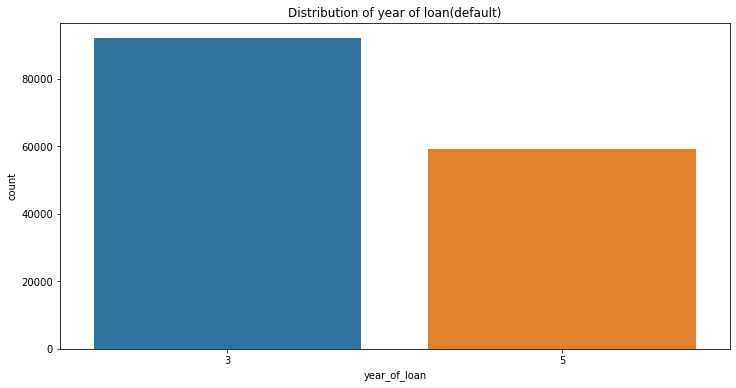

The average of year of loan is  4


In [64]:
data_default=data[(data['isDefault'] ==1)]
plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'year_of_loan', data = data_default)
plt.title('Distribution of year of loan(default)')
plt.show()
avg_year_of_loan=round(np.mean(data_default['year_of_loan']))
print("The average of year of loan is ",avg_year_of_loan)

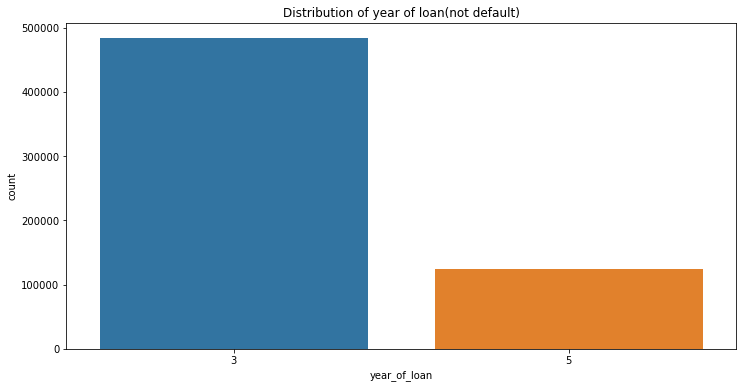

The average of year of loan is  3


In [65]:
data_notdefault=data[(data['isDefault'] ==0)]
plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'year_of_loan', data = data_notdefault)
plt.title('Distribution of year of loan(not default)')
plt.show()
avg_year_of_loan=round(np.mean(data_notdefault['year_of_loan']))
print("The average of year of loan is ",avg_year_of_loan)

In [66]:
# It shows that bank offer the 3 or 5 years of loan frequently.
# The year of loan of these defaulters is concentrated on three years
# It seems that defaulters do not have ability to return in short time.

In [67]:
# Maybe the interest is too high that they can not afford instantly?
# Let's look at the distribution of interest

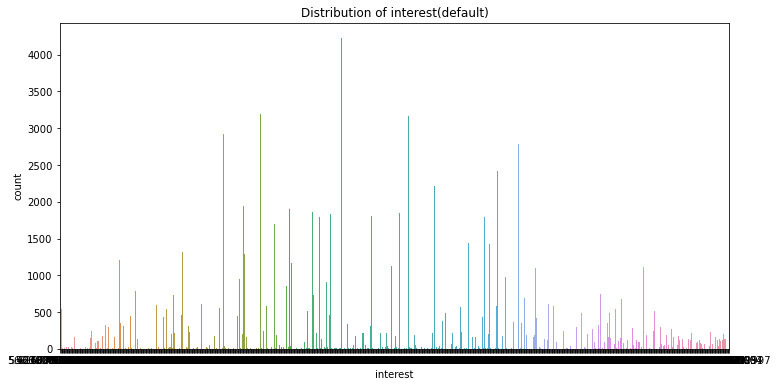

In [68]:
plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'interest', data = data_default)
plt.title('Distribution of interest(default)')
plt.show()


In [69]:
print(data_default['interest'].describe())

count   151133.000
mean        15.715
std          4.908
min          4.788
25%         12.290
50%         15.050
75%         18.550
max         33.869
Name: interest, dtype: float64


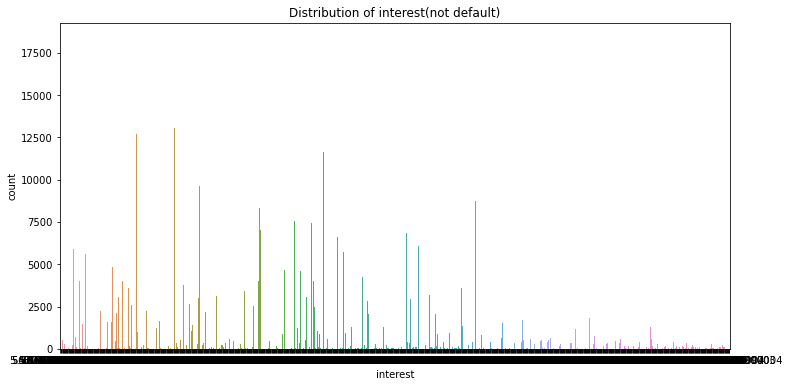

In [70]:
plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'interest', data = data_notdefault)
plt.title('Distribution of interest(not default)')
plt.show()

In [71]:
print(data_notdefault['interest'].describe())

count   607766.000
mean        12.624
std          4.528
min          4.779
25%          9.170
50%         12.180
75%         15.310
max         33.979
Name: interest, dtype: float64


In [72]:
# We could see that the interval of default's interst is (4.788,33.869)
# the interval of not default's interst is (4.779,33.979)
# the gap of interval is not big
# but the mean of default's interest is higher than not default.
# It seems that people could not afford the high interest that making loan default

In [73]:
data.head()

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,post_code,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_mon
0,1040418,31818.182,3,11.466,1174.910,2,3,13,3.000,0,193.000,2.430,0.000,556.364,649.091,0.000,7734.231,91.800,0,200112,3,9927,0.000,0,201610
1,1025197,28000.000,5,16.841,670.690,2,3,13,10.000,0,491.000,11.005,1.000,715.000,893.750,0.000,31329.000,54.800,1,199004,0,0,0.000,0,201306
2,1009360,17272.727,3,8.900,603.320,0,3,3,10.000,1,459.000,6.409,0.000,774.545,903.636,0.000,18514.000,57.692,1,199110,0,0,0.000,0,201401
3,1039708,20000.000,3,4.788,602.300,0,1,10,6.000,0,157.000,9.205,0.000,750.000,875.000,0.000,20707.000,42.600,0,200106,0,0,0.000,0,201507
4,1027483,15272.727,3,12.790,470.310,2,3,2,0.000,2,38.000,15.578,0.000,609.091,710.606,0.000,14016.154,30.462,0,200205,0,0,0.000,0,201607


In [74]:
# Most defaulters have 3 years of loan. 
# Do defaulters who have three years of loan pay more monthly payment than those who have five years of loan?

In [75]:
data_default_3=data_default[(data_default['year_of_loan'])==3]
data_default_3.head()
data_default_5=data_default[(data_default['year_of_loan'])==5]
data_default_5.head()

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,post_code,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_mon
16,1010877,35000.000,5,12.690,790.820,2,0,7,3.000,0,19.000,27.450,0.000,805.000,939.167,0.000,3976.615,8.615,0,199512,0,0,0.000,1,201504
19,1020141,8181.818,5,17.171,241.120,3,4,13,10.000,1,95.000,14.136,1.000,670.000,837.500,0.000,13693.077,73.900,0,199411,0,0,0.000,1,201503
20,1033907,41363.636,5,15.939,823.310,2,4,11,10.000,0,63.000,12.993,0.000,540.000,675.000,0.000,47656.000,73.662,1,200310,0,0,0.000,1,201611
28,1029038,27409.091,5,12.591,779.320,2,1,9,10.000,0,29.000,15.850,1.000,631.818,684.470,0.000,13350.000,98.885,0,200202,0,0,0.000,1,201506
63,1016985,10400.000,5,19.338,261.730,3,0,11,10.000,1,143.000,8.930,0.000,593.182,741.477,1.000,921.846,5.423,1,200104,0,0,0.000,1,201109


In [76]:
data_default_3['monthly_payment'].describe()

count   92008.000
mean      432.461
std       288.405
min        30.120
25%       220.310
50%       344.020
75%       564.810
max      1715.420
Name: monthly_payment, dtype: float64

In [77]:
data_default_5['monthly_payment'].describe()

count   59125.000
mean      515.477
std       206.640
min        22.790
25%       353.800
50%       477.930
75%       640.680
max      1318.570
Name: monthly_payment, dtype: float64

In [78]:
# It's surprising that the average monthly payment for a 3-year loan is less than that for a 5-year loan.
# Could it be that loans are too high a share of income?
# Let's continue to look at the debt-to-income ratios of these people.

In [79]:
data_default_3['debt_loan_ratio'].describe()

count   92008.000
mean       19.765
std        13.365
min         0.000
25%        12.990
50%        19.320
75%        25.920
max       999.000
Name: debt_loan_ratio, dtype: float64

In [80]:
data_default_5['debt_loan_ratio'].describe()

count   59125.000
mean       20.847
std        11.504
min         0.000
25%        14.360
50%        20.380
75%        26.900
max       999.000
Name: debt_loan_ratio, dtype: float64

In [81]:
# It seems that the debt-to-income ratio is about the same for people with 3-year and 5-year defaults.
# Could it be because these people are just starting out in the workforce and don't have a steady and substantial income?
# Then look at years of work

In [82]:
data_default_3['work_year'].describe()

count   92008.000
mean        5.007
std         4.029
min        -1.000
25%         1.000
50%         5.000
75%        10.000
max        10.000
Name: work_year, dtype: float64

In [83]:
data_default_5['work_year'].describe()

count   59125.000
mean        5.779
std         3.906
min        -1.000
25%         2.000
50%         6.000
75%        10.000
max        10.000
Name: work_year, dtype: float64

In [84]:
# These people have been working for about the same number of years, 
#maybe it's because some of them don't have a house and need to pay rent

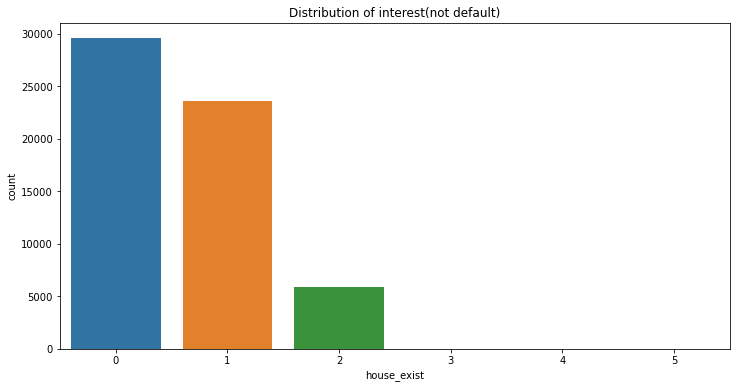

In [85]:
plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'house_exist', data = data_default_5)
plt.title('Distribution of interest(not default)')
plt.show()

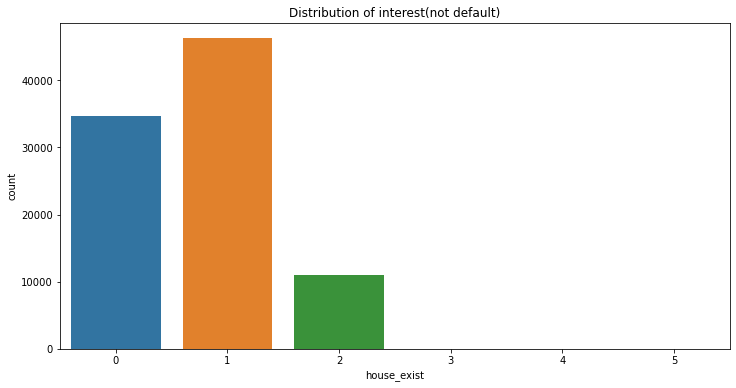

In [86]:
plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'house_exist', data = data_default_3)
plt.title('Distribution of interest(not default)')
plt.show()

In [87]:
# It is strange that more than half of the defaulters have one or even two houses,
# so it seems that rent and debt-to-income ratio is not the main reason for default.

count   151133.000
mean         0.354
std          0.944
min          0.000
25%          0.000
50%          0.000
75%          0.000
max         27.000
Name: del_in_18month, dtype: float64


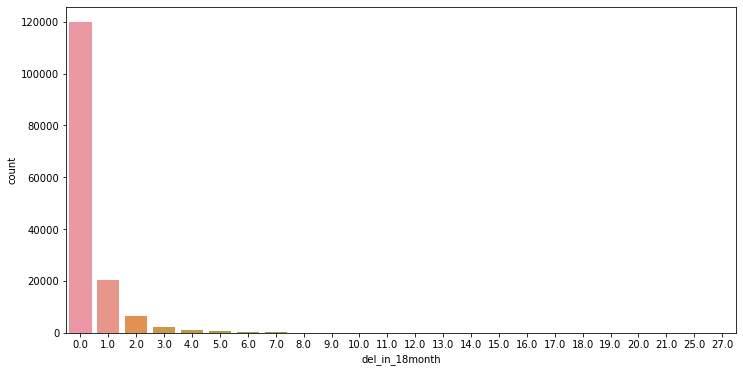

In [88]:
# data is too unevenly distributed, with the vast majority of data being 0. 
# This suggests that the vast majority of people are not intentionally defaulting on their loans and that they have had better credit recently.。
print(data_default['del_in_18month'].describe())
plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'del_in_18month', data = data_default)

count   151133.000
mean    201521.165
std        151.311
min     200710.000
25%     201410.000
50%     201510.000
75%     201608.000
max     201812.000
Name: issue_mon, dtype: float64


201603    5988
201510    4651
201507    4649
201512    4535
201410    4070
201602    3832
201504    3730
201501    3682
201511    3648
201508    3512
201604    3493
201505    3263
201607    3239
201608    3234
201506    3055
201601    3046
201509    2951
201407    2918
201606    2857
201612    2731
201503    2696
201605    2622
201611    2545
201411    2487
201502    2400
201609    2388
201610    2379
201703    2225
201705    2148
201701    2086
201707    2064
201708    2040
201706    2023
201709    1894
201405    1868
201408    1868
201404    1855
201406    1755
201702    1748
201704    1736
201403    1548
201710    1467
201402    1455
201711    1438
201401    1417
201312    1291
201311    1289
201310    1229
201712    1184
201309    1174
201307    1073
201409    1045
201308    1037
201412     978
201306     966
201305     956
201801     934
201304     843
201803     790
201804     774
201802     753
201303     700
201805     669
201302     639
201211     598
201301     593
201210    

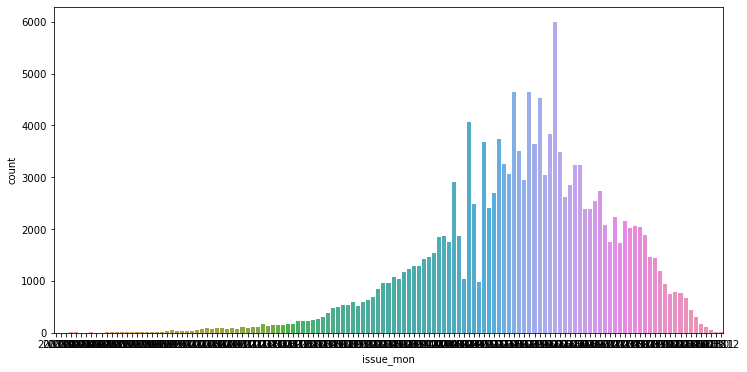

In [89]:
print(data_default['issue_mon'].describe())
plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'issue_mon', data = data_default)
data_default['issue_mon'].value_counts()

In [90]:
data_default=data_default[~data_default.index.duplicated()]

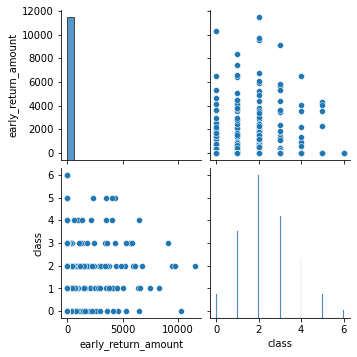

In [91]:
sns.pairplot(data_default,vars=['early_return_amount','class' ]) 

In [92]:
data_default.head()


,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,post_code,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_mon
13,1049951,1636.364,3,17.091,65.980,3,4,1,10.000,1,255.000,23.140,0.000,660.000,770.000,0.000,5049.000,108.769,0,200308,0,0,0.000,1,201605
16,1010877,35000.000,5,12.690,790.820,2,0,7,3.000,0,19.000,27.450,0.000,805.000,939.167,0.000,3976.615,8.615,0,199512,0,0,0.000,1,201504
19,1020141,8181.818,5,17.171,241.120,3,4,13,10.000,1,95.000,14.136,1.000,670.000,837.500,0.000,13693.077,73.900,0,199411,0,0,0.000,1,201503
20,1033907,41363.636,5,15.939,823.310,2,4,11,10.000,0,63.000,12.993,0.000,540.000,675.000,0.000,47656.000,73.662,1,200310,0,0,0.000,1,201611
25,1033417,17727.273,3,17.091,549.770,3,5,2,0.000,1,171.000,22.778,0.000,741.818,865.455,0.000,11990.462,62.138,1,201208,0,0,0.000,1,201611


count   151133.000
mean    201521.165
std        151.311
min     200710.000
25%     201410.000
50%     201510.000
75%     201608.000
max     201812.000
Name: issue_mon, dtype: float64


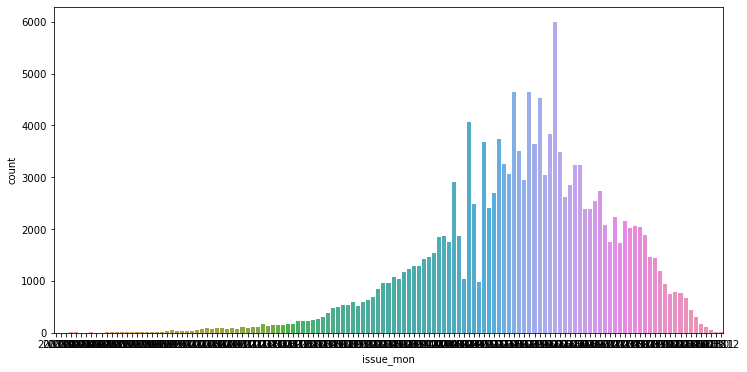

In [93]:
data_default['issue_mon'].value_counts()
print(data_default['issue_mon'].describe())
plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'issue_mon', data = data_default)


In [94]:
# data_default['issue_mon'==201603]

In [95]:
default_rate=data_default['issue_mon'].value_counts()/(data['issue_mon'].value_counts())
default_rate

200708     nan
200710   1.000
200711     nan
200801   0.667
200802   0.250
200803   0.123
200804   0.190
200805   0.091
200806   0.125
200807   0.196
200808   0.029
200809   0.222
200810   0.153
200811   0.167
200812   0.174
200901   0.124
200902   0.138
200903   0.139
200904   0.144
200905   0.103
200906   0.133
200907   0.109
200908   0.116
200909   0.102
200910   0.147
200911   0.134
200912   0.099
201001   0.126
201002   0.103
201003   0.098
201004   0.103
201005   0.133
201006   0.163
201007   0.132
201008   0.134
201009   0.164
201010   0.127
201011   0.138
201012   0.116
201101   0.141
201102   0.117
201103   0.137
201104   0.137
201105   0.177
201106   0.133
201107   0.155
201108   0.134
201109   0.132
201110   0.142
201111   0.139
201112   0.182
201201   0.159
201202   0.152
201203   0.147
201204   0.145
201205   0.160
201206   0.173
201207   0.184
201208   0.162
201209   0.153
201210   0.154
201211   0.164
201212   0.153
201301   0.155
201302   0.151
201303   0.150
201304   0

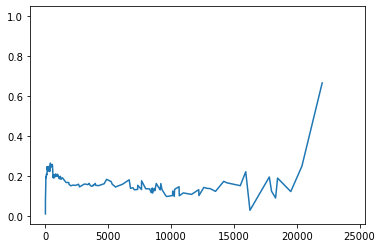

In [96]:
# Prepare Data
x = data['issue_mon'].value_counts()
y = (data_default['issue_mon'].value_counts()/data['issue_mon'].value_counts())

plt.plot(x,y)
plt.show()

# Separate out the features and targets

In [97]:
print(data.isna().any())

loan_id                     False
total_loan                  False
year_of_loan                False
interest                    False
monthly_payment             False
class                       False
employer_type               False
industry                    False
work_year                   False
house_exist                 False
post_code                   False
debt_loan_ratio             False
del_in_18month              False
scoring_low                 False
scoring_high                False
pub_dero_bankrup            False
recircle_b                  False
recircle_u                  False
initial_list_status         False
earlies_credit_mon          False
early_return                False
early_return_amount         False
early_return_amount_3mon    False
isDefault                   False
issue_mon                   False
dtype: bool


In [98]:
data_ML=data.dropna(subset=['isDefault'])

In [99]:
from sklearn import preprocessing,metrics 
# Separate out the features and targets
X = data_ML.drop(['isDefault'],axis=1)
Y = data_ML.isDefault
X=X.fillna(0)
Y=Y.fillna(0)

In [100]:
data_ML.shape

(758899, 25)

In [101]:
X.head()

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,post_code,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,early_return,early_return_amount,early_return_amount_3mon,issue_mon
0,1040418,31818.182,3,11.466,1174.910,2,3,13,3.000,0,193.000,2.430,0.000,556.364,649.091,0.000,7734.231,91.800,0,200112,3,9927,0.000,201610
1,1025197,28000.000,5,16.841,670.690,2,3,13,10.000,0,491.000,11.005,1.000,715.000,893.750,0.000,31329.000,54.800,1,199004,0,0,0.000,201306
2,1009360,17272.727,3,8.900,603.320,0,3,3,10.000,1,459.000,6.409,0.000,774.545,903.636,0.000,18514.000,57.692,1,199110,0,0,0.000,201401
3,1039708,20000.000,3,4.788,602.300,0,1,10,6.000,0,157.000,9.205,0.000,750.000,875.000,0.000,20707.000,42.600,0,200106,0,0,0.000,201507
4,1027483,15272.727,3,12.790,470.310,2,3,2,0.000,2,38.000,15.578,0.000,609.091,710.606,0.000,14016.154,30.462,0,200205,0,0,0.000,201607


In [102]:
data_sumbit=pd.read_csv('data_sumbit.csv')
data_sumbit

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,post_code,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,early_return,early_return_amount,early_return_amount_3mon,issue_mon
0,4654864,1000,5,6,17,1,1,1,3,1,465,1,0,500,660,0,90,0,202002,0,0,0,0,0


In [103]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: isDefault, dtype: int64

# Scaling Data

In [104]:
# Initializing the MinMaxScaler 
min_max_scaler=preprocessing.MinMaxScaler()

In [105]:
# Scaling dataset keeping the columns name
X_scaled = pd.DataFrame(min_max_scaler.fit_transform(X), columns = X.columns)
X_scaled.head()

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,post_code,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,early_return,early_return_amount,early_return_amount_3mon,issue_mon
0,0.991,0.668,0.000,0.229,0.681,0.333,0.600,1.000,0.364,0.000,0.205,0.003,0.000,0.044,0.117,0.000,0.003,0.103,0.000,0.700,0.103,0.539,0.000,0.817
1,0.976,0.586,1.000,0.413,0.384,0.333,0.600,1.000,1.000,0.000,0.522,0.012,0.026,0.472,0.565,0.000,0.011,0.061,1.000,0.542,0.000,0.000,0.000,0.542
2,0.961,0.356,0.000,0.141,0.344,0.000,0.600,0.231,1.000,0.200,0.488,0.007,0.000,0.632,0.583,0.000,0.006,0.065,1.000,0.557,0.000,0.000,0.000,0.628
3,0.990,0.414,0.000,0.000,0.344,0.000,0.200,0.769,0.636,0.000,0.167,0.010,0.000,0.566,0.530,0.000,0.007,0.048,0.000,0.699,0.000,0.000,0.000,0.724
4,0.979,0.313,0.000,0.274,0.266,0.333,0.600,0.154,0.091,0.400,0.040,0.017,0.000,0.186,0.230,0.000,0.005,0.034,0.000,0.714,0.000,0.000,0.000,0.814


In [106]:
# Splitting  up data, seting 70% for train and 30% for test.
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=1103)

In [107]:
x_test

,loan_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,post_code,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,early_return,early_return_amount,early_return_amount_3mon,issue_mon
437650,0.704,0.199,0.000,0.088,0.171,0.000,0.600,1.000,1.000,0.400,0.182,0.023,0.026,0.418,0.208,0.000,0.007,0.059,0.000,1.000,0.000,0.000,0.000,0.909
265857,0.166,0.522,1.000,0.213,0.309,0.167,0.800,1.000,1.000,0.200,0.699,0.039,0.000,0.526,0.282,0.000,0.009,0.051,0.000,1.000,0.000,0.000,0.000,0.719
116828,0.553,0.113,0.000,0.257,0.106,0.333,0.600,0.308,0.727,0.000,0.524,0.010,0.000,0.364,0.172,0.000,0.002,0.034,0.000,0.999,0.000,0.000,0.000,0.726
457864,0.190,0.327,0.000,0.271,0.304,0.333,0.800,0.846,0.091,0.200,0.241,0.028,0.026,0.350,0.163,0.000,0.005,0.099,0.000,0.999,0.000,0.000,0.000,0.726
200223,0.303,0.522,1.000,0.268,0.321,0.333,0.800,0.000,0.455,0.400,0.238,0.036,0.000,0.337,0.154,0.000,0.004,0.083,0.000,0.999,0.000,0.000,0.000,0.994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398764,0.196,0.414,1.000,0.487,0.294,0.667,0.800,1.000,1.000,0.000,0.243,0.025,0.000,0.431,0.218,0.000,0.006,0.090,0.000,0.999,0.000,0.000,0.000,0.637
526717,0.680,0.259,1.000,0.196,0.151,0.167,0.000,0.154,0.364,0.200,0.177,0.021,0.000,0.688,0.391,0.000,0.001,0.005,0.000,0.999,0.000,0.000,0.000,0.901
39509,0.527,0.176,0.000,0.370,0.172,0.500,0.400,0.000,0.091,0.200,0.267,0.020,0.026,0.337,0.154,0.000,0.002,0.046,1.000,0.999,0.000,0.000,0.000,0.637
145229,0.415,0.156,0.000,0.080,0.134,0.000,0.600,1.000,0.364,0.200,0.515,0.003,0.000,0.580,0.318,0.000,0.002,0.014,0.000,0.999,0.552,0.123,0.144,0.636


In [108]:
from sklearn.model_selection import train_test_split # To split data
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.metrics import confusion_matrix # To calculate the confusion matrix
from sklearn.metrics import accuracy_score # To calculate the score
from sklearn.feature_selection import SelectKBest # Univariate Feature Selection
from sklearn.feature_selection import chi2 # To apply Univariate Feature Selection
from sklearn.feature_selection import RFE # Recursive Feature Selection
from sklearn.feature_selection import RFECV # Recursive Feature Selection with Cross Validation
from sklearn.decomposition import PCA # To apply PCA
from sklearn import preprocessing # To get MinMax Scaler function
import seaborn as sns # To display visualizations.
import matplotlib.pyplot as plt # To plot
# To plot inline
%matplotlib inline

# Univariate Feature Selection

In [109]:
# Initialize SelectKBest
UnivariateFeatureSelection = SelectKBest(chi2, k=6).fit(x_train, y_train)

In [110]:
# Creating a dict to visualize which features were selected with the highest score
dictionary = {key:value for (key, value) in zip(UnivariateFeatureSelection.scores_, x_train.columns)}
sorted(dictionary.items())

[(0.07010592635767485, 'earlies_credit_mon'),
 (0.30287097804746116, 'industry'),
 (0.315972313027132, 'loan_id'),
 (2.4993957285390755, 'recircle_b'),
 (4.628331763531479, 'post_code'),
 (12.796379747320705, 'del_in_18month'),
 (15.17181977862582, 'initial_list_status'),
 (23.981375013272118, 'recircle_u'),
 (25.212460478122477, 'debt_loan_ratio'),
 (36.85725102412975, 'pub_dero_bankrup'),
 (44.542703296725236, 'issue_mon'),
 (121.82865756045024, 'work_year'),
 (125.95285881643596, 'monthly_payment'),
 (152.28684233653772, 'scoring_high'),
 (159.06072458342175, 'scoring_low'),
 (251.76761511118912, 'house_exist'),
 (253.48900412776732, 'total_loan'),
 (392.98379490802404, 'employer_type'),
 (850.4321086725118, 'early_return_amount'),
 (992.6598876122657, 'early_return_amount_3mon'),
 (3277.12925553469, 'interest'),
 (5464.5920194791715, 'early_return'),
 (5828.863631996482, 'class'),
 (12280.186793381783, 'year_of_loan')]

<p>
<span style="color:blue">
    Data Encoding<br>
>It is obvious that the last five features have the highest score. <br>
>So the best features are<br>
    >'year_of_loan'<br>
    >'class'<br>
    >'early_return'<br>
    >'interest'<br>
    >'early_return_amount_3mon'<br>
    >'early_return_amount'<br>
   
</span>
</p>



# Extracting the best K values

In [111]:
# Using the 'UnivariateFeatureSelection' based on 'SelectKBest' function,
# let's extract the best features from the original dataset

x_train_k_best = UnivariateFeatureSelection.transform(x_train)
x_test_k_best = UnivariateFeatureSelection.transform(x_test)
data_sumbit_best=UnivariateFeatureSelection.transform(data_sumbit)

In [112]:
data_sumbit_best

array([[5, 6, 1, 0, 0, 0]], dtype=int64)

In [113]:
print("Shape of original data: ", x_train.shape)
print("Shape of corpus with best features: ", x_train_k_best.shape)

Shape of original data:  (531229, 24)
Shape of corpus with best features:  (531229, 6)


# ROC Curve plot function

In [114]:
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
# This function prints and plots the ROC Curve
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

# Confusion_matrix

In [115]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Random Forest Algorithm

In [116]:
# Initializing and fitting data to the random forest classifier
RandForest_K_best = RandomForestClassifier()      
RandForest_K_best = RandForest_K_best.fit(x_train_k_best, y_train)

In [117]:
# Making a prediction
rfPredict = RandForest_K_best.predict(x_test_k_best)
# For ROC curve
rfPredictproba = RandForest_K_best.predict_proba(x_test_k_best)[:,1]
# calculting the accuracy
rfAccuracy = accuracy_score(y_test, rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print('Accuracy: ',rfAccuracy)

Accuracy:  0.8026046470769096


findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.


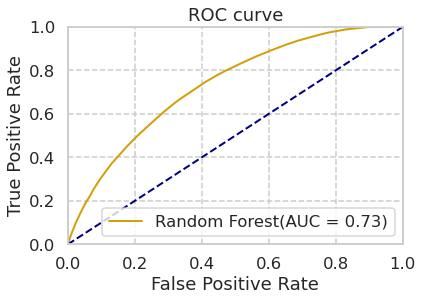

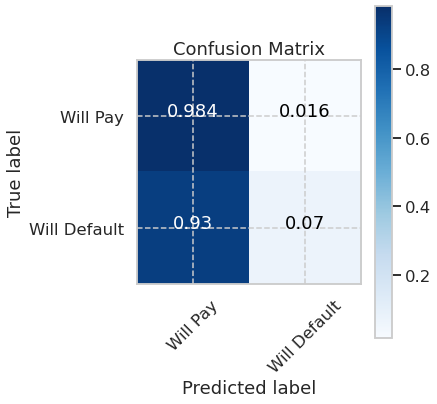

In [118]:
plotAUC(y_test,rfPredictproba, 'Random Forest')
plt.savefig('RF_AUC.png')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.savefig('RF_confusion_matrix.png')
plt.show()

# Logistic Regression 

In [129]:
from sklearn import linear_model
logr = linear_model.LogisticRegression()
# Initializing and fitting data to the linear_model
logr.fit(x_train_k_best,y_train)
LR_Predict = logr.predict_proba(x_test_k_best)[:,1]
LR_Predict_bin = logr.predict(x_test_k_best)
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
print("Logistic regression accuracy is ",LR_Accuracy)
# plotAUC(y_test,rfPredictproba, 'Random Forest')
# plotAUC(y_test,LR_Predict,'Logistic Regression')
# plt.savefig('LR_AUC.png')
# plt.show()
# plt.figure(figsize=(6,6))
# plot_confusion_matrix(LR_Predict_bin, normalize=True)
# plt.savefig('LR_confusion_matrix.png')
# plt.show()
data_sumbit_Predict=logr.predict(data_sumbit_best)


Logistic regression accuracy is  0.802001144502055


In [130]:
y_test
print(data_sumbit_Predict)

[1]


In [85]:
# from sklearn.svm import SVC
# svm = SVC()
# svm.fit(x_train_k_best,y_train)
# predictions_svm = svm.predict(x_test_k_best)
# predictproba_svm = svm.decision_function(x_test_k_best)[:,1]
# SVM_Accuracy = accuracy_score(y_test,predictions_svm)
# print("SVM accuracy is ",SVM_Accuracy)
# plotAUC(y_test,predictproba_svm, 'SVM')
# plotAUC(y_test,rfPredictproba, 'Random Forest')
# plotAUC(y_test,LR_Predict,'Logistic Regression')
# plt.show()
# plt.figure(figsize=(6,6))
# plot_confusion_matrix(predictions_svm, normalize=True)
# plt.show()

# MLP

0.8027598106369327


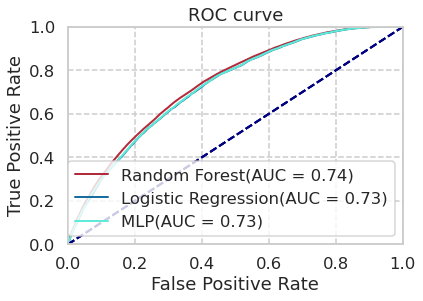

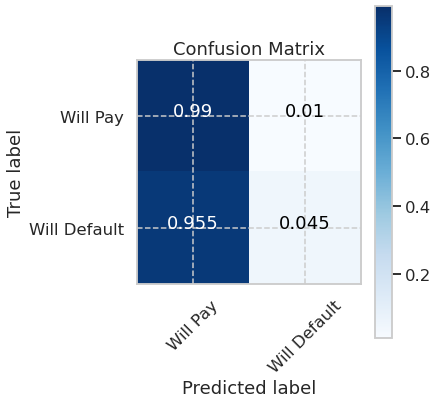

In [86]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier()
MLP.fit(x_train_k_best,y_train)     
predict_NN = MLP.predict(x_test_k_best)
predictproba_NN = MLP.predict_proba(x_test_k_best)[:,1]
NNAccuracy = accuracy_score(y_test,predict_NN)
print(NNAccuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_NN,'MLP')
plt.savefig('MLP_AUC.png')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predict_NN, normalize=True)
plt.savefig('MLP_confusion_matrix.png')
plt.show()

# KNN

0.8027598106369327


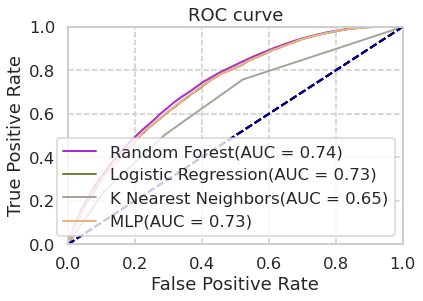

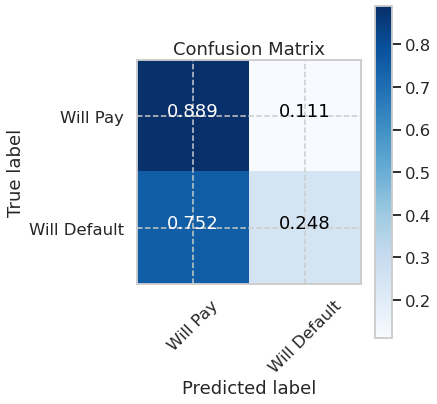

In [87]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()
KNN.fit(x_train_k_best,y_train)
knn_pred = KNN.predict(x_test_k_best)
knn_predictproba = KNN.predict_proba(x_test_k_best)[:,1]
KNN_Acc = accuracy_score(y_test,knn_pred)
print(NNAccuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plotAUC(y_test,predictproba_NN,'MLP')
plt.savefig('KNN_AUC.png') 
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(knn_pred, normalize=True)
plt.savefig('KNN_confusion_matrix.png')
plt.show()

In [88]:
from sklearn.metrics import classification_report
print("RF",classification_report(y_test, rfPredict, target_names=None))
print("LR",classification_report(y_test, LR_Predict_bin, target_names=None))
print("KNN",classification_report(y_test, knn_pred, target_names=None))
print("MLP",classification_report(y_test, predict_NN, target_names=None))

RF               precision    recall  f1-score   support

           0       0.81      0.98      0.89    185051
           1       0.54      0.07      0.13     45617

    accuracy                           0.80    230668
   macro avg       0.67      0.53      0.51    230668
weighted avg       0.76      0.80      0.74    230668

LR               precision    recall  f1-score   support

           0       0.81      0.98      0.89    185051
           1       0.50      0.08      0.13     45617

    accuracy                           0.80    230668
   macro avg       0.65      0.53      0.51    230668
weighted avg       0.75      0.80      0.74    230668

KNN               precision    recall  f1-score   support

           0       0.83      0.89      0.86    185051
           1       0.36      0.25      0.29     45617

    accuracy                           0.76    230668
   macro avg       0.59      0.57      0.57    230668
weighted avg       0.73      0.76      0.75    230668

MLP      

In [40]:
train = data[data['isDefault'].notna()]
test  = data[data['isDefault'].isna()]

ycol = 'isDefault'
feature_names = list(
    filter(lambda x: x not in [ycol, 'loan_id'], train.columns))

model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt',
                           tree_learner='serial',
                           num_leaves=32,
                           max_depth=6,
                           learning_rate=0.1,
                           n_estimators=10000,
                           subsample=0.8,
                           feature_fraction=0.6,
                           reg_alpha=0.5,
                           reg_lambda=0.5,
                           random_state=2021,
                           is_unbalance=True,
                           metric='auc')


oof = []
prediction = test[['loan_id']]
prediction[ycol] = 0
df_importance_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(train[feature_names], train[ycol])):
    X_train = train.iloc[trn_idx][feature_names]
    Y_train = train.iloc[trn_idx][ycol]

    X_val = train.iloc[val_idx][feature_names]
    Y_val = train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(fold_id+1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=500,
                          eval_metric='auc',
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(
        X_val, num_iteration=lgb_model.best_iteration_)
    df_oof = train.iloc[val_idx][['loan_id', ycol]].copy()
    df_oof['pred'] = pred_val[:, 1]
    oof.append(df_oof)

    pred_test = lgb_model.predict_proba(
        test[feature_names], num_iteration=lgb_model.best_iteration_)
    prediction[ycol] += pred_test[:, 1] / kfold.n_splits

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)


Fold_1 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[372]	train's auc: 0.815519	valid's auc: 0.800653

Fold_2 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[372]	train's auc: 0.815138	valid's auc: 0.801505

Fold_3 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[315]	train's auc: 0.813119	valid's auc: 0.803128

Fold_4 Training ====================

In [45]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg(
    'mean').sort_values(ascending=False).reset_index()

TypeError: to_excel() missing 1 required positional argument: 'excel_writer'

In [50]:
df_importance=pd.DataFrame(df_importance)
df_importance.to_excel('df_importance.xlsx')